In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

In [2]:
# This converter function will convert the string into corresponding value.
#def converter1(x):
#    if x == b'A' or x == b'B' or x == b'C' or x == b'D' or x == b'E' or x == b'F' or x == b'G' or x == b'H' or x == b'I' or x == b'J' or x == b'K' or x == b'L' or x == b'M':       
#        return 1
#    else:
#        return 0
def converter1(x):
    if ord(x)-ord(b'M') > 0:
        return 0
    else:
        return 1

In [3]:
column1 = 0

data = np.loadtxt('letter-recognition.data', delimiter=',', 
               converters={column1:converter1})

In [4]:
print(data)
print(data.shape)

[[  0.   2.   8. ...,   8.   0.   8.]
 [  1.   5.  12. ...,   8.   4.  10.]
 [  1.   4.  11. ...,   7.   3.   9.]
 ..., 
 [  0.   6.   9. ...,  12.   2.   4.]
 [  0.   2.   3. ...,   9.   5.   8.]
 [  1.   4.   9. ...,   7.   2.   8.]]
(20000, 17)


In [5]:
# Divide data into training and testing sets
X_and_Y = data
np.random.shuffle(X_and_Y)

# Try to predict the last column (the cover type, which is 7 types)
X = X_and_Y[:5000,1:17]
Y = X_and_Y[:5000,0]
print(X.shape, Y.shape)

(5000, 16) (5000,)


In [6]:
X_train_val = X[:int(0.5*len(X))]
X_test      = X[int(0.5*len(X)):]
Y_train_val = Y[:int(0.5*len(Y))]
Y_test      = Y[int(0.5*len(Y)):]
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(2500, 16) (2500, 16) (2500,) (2500,)


In [7]:
# SVM process

# linear
# polynomial degree 2 & 3 (this one is using 3)
# radial with width [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
# regularization parameter C = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

classifier = svm.SVC(kernel='linear')
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3]   
params = {"C": C_list}

GSR = GridSearchCV(classifier, params, return_train_score=True, cv=5, n_jobs=4)
GSR.fit(X_train_val,Y_train_val)
GSR.cv_results_
                               
# May also want to try rbf kernel with sigma (radial width values)

{'mean_fit_time': array([  2.05745745e-01,   2.11549520e-01,   2.32664347e-01,
          2.00441742e-01,   1.82228661e-01,   1.68018866e-01,
          3.17124224e-01,   1.07806158e+00,   5.67909799e+00,
          3.58265870e+01,   3.32888166e+02]),
 'mean_score_time': array([ 0.03522477,  0.0344244 ,  0.03722649,  0.03362393,  0.02651901,
         0.0236166 ,  0.02391696,  0.01931391,  0.01601143,  0.0147109 ,
         0.01441517]),
 'mean_test_score': array([ 0.5088,  0.5088,  0.5088,  0.6796,  0.7132,  0.7368,  0.738 ,
         0.738 ,  0.738 ,  0.7376,  0.738 ]),
 'mean_train_score': array([ 0.5088    ,  0.5088    ,  0.5088    ,  0.68130109,  0.71970014,
         0.74620035,  0.74629985,  0.7466994 ,  0.7467994 ,  0.7466994 ,
         0.74649945]),
 'param_C': masked_array(data = [1e-07 1e-06 1e-05 0.0001 0.001 0.01 0.1 1.0 10.0 100.0 1000.0],
              mask = [False False False False False False False False False False False],
        fill_value = ?),
 'params': ({'C': 1e-07},


In [8]:
# find best C and best accuracy
test_acc = sum(GSR.best_estimator_.predict(X_test) == Y_test) / len(X_test)
print(GSR.best_params_)
print(test_acc)

{'C': 0.1}
0.7256


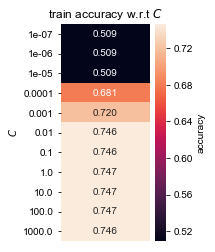

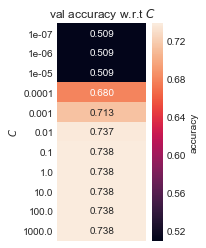

In [9]:
def draw_heatmap_linear(acc, acc_desc, C_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
results = GSR.cv_results_

train_acc = np.matrix(results.get("mean_train_score")).T
draw_heatmap_linear(train_acc, 'train accuracy', C_list)

val_acc = np.matrix(results.get("mean_test_score")).T
draw_heatmap_linear(val_acc, 'val accuracy', C_list)

In [10]:
def convert_to_gamma(radial_width):
    converted = [0]*len(radial_width)
    for i in range(len(radial_width)):
        gamma = 1/(2*(radial_width[i]**2))
        converted[i] = gamma
    return converted

radial_width = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
gamma_list = convert_to_gamma(radial_width)

# SVM process

# rbf
# polynomial degree 2 & 3 (this one is using 3)
# radial with width [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
# regularization parameter C = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

classifier = svm.SVC(kernel='rbf')
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3]
params = {"C": C_list, "gamma": gamma_list}

GSR = GridSearchCV(classifier, params, return_train_score=True, cv=5, n_jobs=4)
GSR.fit(X_train_val,Y_train_val)
GSR.cv_results_
                               
# May also want to try rbf kernel with sigma (radial width values)

{'mean_fit_time': array([ 0.66867189,  0.56700048,  0.53868051,  0.55549202,  0.55018888,
         1.20315046,  0.73331819,  0.32272811,  0.55629292,  0.6043272 ,
         0.57020278,  0.55158963,  0.54448457,  1.15871882,  0.67797894,
         0.32553   ,  0.58291197,  0.60532742,  0.5508893 ,  0.52877369,
         0.53657899,  1.11038437,  0.6793797 ,  0.31572299,  0.52897358,
         0.5187665 ,  0.51356249,  0.5304749 ,  0.5221693 ,  1.15251451,
         0.74502711,  0.32823086,  0.55549216,  0.56810036,  0.52206831,
         0.53217559,  0.53727899,  1.0917706 ,  0.70329652,  0.32462921,
         0.56029572,  0.54794526,  0.53367767,  0.52777281,  0.532476  ,
         1.06565313,  0.67597742,  0.32242785,  0.55919499,  0.60322638,
         0.56259737,  0.58691444,  0.56029592,  1.09667506,  0.70279636,
         0.32142639,  0.60602775,  0.61843781,  0.62714319,  0.67457671,
         0.64785705,  1.17673116,  0.87541852,  0.42970386,  0.68018055,
         0.69268913,  0.71850739, 

In [11]:
# find best C and best accuracy
test_acc = sum(GSR.best_estimator_.predict(X_test) == Y_test) / len(X_test)
print(GSR.best_params_)
print(test_acc)

{'C': 1.0, 'gamma': 0.125}
0.9324


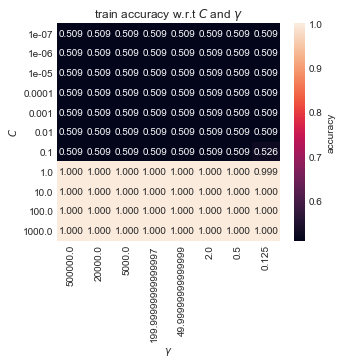

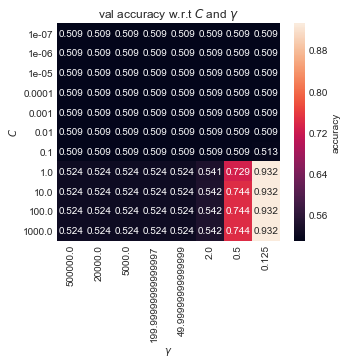

In [12]:
def draw_heatmap_RBF(acc, acc_desc, gamma_list, C_list):
    plt.figure(figsize = (5,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', 
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = '$\gamma$', ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$ and $\gamma$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()   

train_acc = GSR.cv_results_['mean_train_score'].reshape(11,8)
draw_heatmap_RBF(train_acc, 'train accuracy', gamma_list, C_list)

val_acc = GSR.cv_results_['mean_test_score'].reshape(11,8)
draw_heatmap_RBF(val_acc, 'val accuracy',gamma_list, C_list)

In [13]:
# KNN
k_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
#k_list = [1,5,8]
params = {"n_neighbors": k_list}
knn = KNeighborsClassifier(n_neighbors=26)
kgs=GridSearchCV(knn, params)
knn.fit(X_train_val, Y_train_val)
knn.predict(X_test)

array([ 0.,  1.,  0., ...,  1.,  0.,  1.])

In [14]:
# compute accuracy
test_acc = np.sum(knn.predict(X_test)==Y_test) / len(X_test)
print(test_acc)

0.8532


In [15]:
# Random Forest
rf = RandomForestClassifier(n_estimators=1024, random_state=0)
rf.fit(X_train_val, Y_train_val)
rf.predict(X_test)

array([ 0.,  1.,  0., ...,  1.,  0.,  1.])

In [16]:
# compute accuracy
test_acc = np.sum(rf.predict(X_test)==Y_test) / len(X_test)
print(test_acc)

0.93
